# **Assignment 1: Rendering systems**

## ECSE 446/546: Realistic/Advanced Image Synthesis, Fall 2021

#### Due: Wednesday, October 13, 2021 at 11:59pm EST on [myCourses](https://mycourses2.mcgill.ca/)

#### Weight: 25% (ECSE 446) / 20% (ECSE 546)

*In this assignment, you will implement the techniques discussed in the 'Rendering Systems' module. You will implement key components of **rasterization** and **ray tracing** pipelines.*

Since evaluation for this assignment is partly automated, it is important that you fill in your code **only in the cells indicated**. If needed, extra cells may be added, but only at the end of the notebook. Any cells added in between will very likely present issues with the autograder.

The *bonus* questions in the end are for extra credit and are optional.


---

## **Assignment Submission Process**

Modify the `ipynb` notebook we provide on myCourses and submit your modified file, renamed according to your student ID, as

<font color="red">A1-[YourStudentID].ipynb</font>

For example, if your student ID is **123456789**, then your submission filename should be **A1-123456789.ipynb**.

> Note that every time you submit a new file, your previous submission will be overwritten.
**All submissions must be made using myCourses.**
You can submit as many times as you like, but we will only grade the last submission.

This assignment is to be completed *individually*.

### Late policy

Failure to submit a (valid) assignment on time will result in a score of **zero (0%)** on the assignment.
**We will not grant extensions.**
Exceptional circumstances will be treated as specified in [McGill's Policies on Student Rights and Responsibilities](https://www.mcgill.ca/students/srr/).

### Plagiarism and cheating
Plagiarism is an academic offense of misrepresenting authorship. This can result in penalties up to expulsion. It is also possible to plagiarise your own work, e.g., by submitting work from another course without proper attribution. When in doubt, attribute!

We expect you to submit your own work. Assignments are individual tasks. That said, we want to promote an environment where you are comfortable discussing ideas together. A good rule to follow: fully understand every solution you submit and only submit code that was written by you.

McGill values academic integrity and students should take the time to fully understand the meaning and consequences of cheating, plagiarism and other academic offenses (as defined in the Code of Student Conduct and Disciplinary Procedures — see these two links [[1]](https://www.mcgill.ca/integrity) [[2]](https://www.mcgill.ca/students/srr/honest)).

In accordance with article 15 of the Charter of Students' Rights, students may submit any written or programming components in either French or English.

### Code comparison

We will use code similarity checkers to detect and deal with cases of plagiarism and cheating.

### Python `import` statements

We provide all import statements required to complete the assignment.
You must not use any `import`s other than the ones we provide.
Doing so will result in a score of **zero (0%)** on the assignment.


---

## **Notes and Tips**

### Debugging in Jupyter Notebook / Google Colab

[Here](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.06-Errors-and-Debugging.ipynb) is a quick tutorial by Jake VanderPlas on how to debug in Jupyter Notebook / Google Colab using `ipdb`.
For a complete list of commands and their usage, check out `pdb`'s [official documentation](https://docs.python.org/3/library/pdb.html).


### OpenEXR Format and EXR Viewer

[OpenEXR](http://www.openexr.com/) is a standardized file format for storing high dynamic range (HDR) images. 
Unlike low dynamic range (LDR) image formats — such as JPG and PNG — HDR image pixel color values are not restricted to the interval $[0, 1]$. 
This allows us to represent luminance ranges similar to the range we experience through the human visual system in the real-world.

**For this assignment though, all output pixel color values in your rendered image should still be clipped to $[0, 1]$.**

We recommend using [tev](https://github.com/Tom94/tev), a lightweight yet powerful EXR viewer that supports various tonemapping operators and pixel-level image inspection and comparison.
To obtain `tev`, follow the OS-specific instruction below:

- Windows / macOS: Download the [pre-built binaries](https://github.com/Tom94/tev/releases). 
If your Mac comes with the Apple M1 chip and you want to to run `tev` natively (not via Rosetta 2), [build it from source](https://github.com/Tom94/tev#macos--linux).
- Linux: Read this [step-by-step guide](https://github.com/Tom94/tev#macos--linux) to build from source.
For Arch Linux and other Arch-based distros (Manjaro, EndeavourOS, etc.), `tev` is available in [AUR](https://aur.archlinux.org/packages/tev/).

### Render time

For each experiment, the default image height and width `imgWidth` and `imgHeight` have been set to `64`. This enables faster debugging.

**Once you think your implementation works, render images of width and height `512` instead of `64`**.


---

## **Preparation**

Let us first install and/or import all necessary modules for this assignment. Note that you are not allowed to import anything apart from the modules in this cell, as they will not be available in our autograding environment.

Run the cell below to install and import all necessary modules.

In [1]:
!pip install pyexr

%matplotlib inline

import math
import time

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im
import pyexr

  Created wheel for pyexr: filename=PyEXR-0.3.10-py2.py3-none-any.whl size=4518 sha256=d70e177ca95629de80e6a2de2c19fb1ec70245f7a4130ecc373b729b082ac448
  Stored in directory: /root/.cache/pip/wheels/da/c8/fb/f00811aa6cb7b74d76ab5941aea24ecf85fd8ca26f1a53ee39
  Created wheel for OpenEXR: filename=OpenEXR-1.3.2-cp37-cp37m-linux_x86_64.whl size=189355 sha256=d53d41cc06e35a0584faaa63016bfee7cf05c866d4aeb2d6261b45071ef2694a
  Stored in directory: /root/.cache/pip/wheels/d1/c6/6c/dcf5d042ed2d547da41021f47957b16bebe9cadfd095765d44
Successfully built pyexr OpenEXR


### Helper Functions

Next, we define some helper functions below that will be useful across the whole assignment.

> **Note**: You are not _required_ to use these helper function implementations. These are only provided to reduce the amount of boilerplate code you need to write.

Specifically,
- `normalize(v)`: Normalizes a vector `v`.
- `distance(a, b)`: Computes the distance between two points `a` and `b`.
- `squaredDistance(a, b)`: Computes the *squared* distance between two points `a` and `b`.
- `perspective(fovy, aspect, near, far)`: Computes the perspective projection matrix.
- `lookAt(eye, at, up)`: Computes the viewing transformation matrix.
- `image2NDC(x, y, width, height)`: Maps the given image coordinate $(x, y)$ into the canonical view volume (or normalized device coordinates, NDC).
- `NDC2Image(x, y, width, height)`: Maps the given coordinate $(x, y)$ in canonical view volume into the screen space.

*Note that you may also want to define your own helper functions in this cell.*

In [70]:
cam_near = 0.1
cam_far = 2000
p = 1

def interpolate_q4(triangle, attr, p):
    """
    Accurate perspective interpolation.
    Parameters:
    triangle: 2D numpy array containing triangle's vertex positions (homogeneous
              coordinates) in NDC space.
        Note that 'triangle' here is in the form of
        [[v0.x, v0.y, v0.z, v0.w], [v1.x, v1.y, v1.z, v1.w], [v2.x, v2.y, v2.z, v2.w]]
        and NOT a Triangle object.
    attr: Attribute to interpolate across the triangle (e.g., position)
    p: Point (in NDC space) at which to compute interpolated attribute
    """
    (alpha, beta, gamma) = barycentric_q4(triangle[0], triangle[1], triangle[2], p)
    return (alpha * attr[0] / triangle[0][3] + beta * attr[1] / triangle[1][3] + gamma * attr[2] / triangle[2][3]) / (
            alpha / triangle[0][3] + beta / triangle[1][3] + gamma / triangle[2][3])


def barycentric_q4(a, b, c, p):
    """
    Compute Barycentric coordinates of point p w.r.t triangle a, b, c.
    Parameters:
    a, b, c: vertices coordinates of the triangle.
    p: the point you want to know its  barycentric coordinates
    """
    a = a / a[-1]
    b = b / b[-1]
    c = c / c[-1]
    area = signedArea(a, b, c)
    alpha = signedArea(b, c, p) / area
    beta = signedArea(c, a, p) / area
    gamma = 1 - alpha - beta
    return alpha, beta, gamma

def rasterize_q4(scene, triangle, img, zbuf):
    """
        Rasterize a single triangle in the scene.
        Parameters:
        scene: an instance of Scene class.
        triangle: the triangle to be rasterized. It is an instance of Triangle class, not vertices in np.array.
    """

    # Scene Configs
    width = scene.config["width"]
    height = scene.config["height"]
    fov = scene.config["fov"] * np.pi / 180.

    # Transformation Matrices
    transform_Cam = lookAt(scene.cam.eye, scene.cam.at, scene.cam.up)
    transform_Pers = perspective(fov, width / height, cam_near, cam_far) @ transform_Cam

    # Triangle Related Vertices
    tri_Wrd3d = np.array(([triangle.v0, triangle.v1, triangle.v2]))
    # 4d versions below
    tri_Wrd = np.array(([np.append(v, 1) for v in tri_Wrd3d]))

    tri_Cam = np.transpose(transform_Cam @ np.transpose(tri_Wrd))
    tri_NDC = np.transpose(transform_Pers @ np.transpose(tri_Wrd))
    v0_NDC4d, v1_NDC4d, v2_NDC4d = tri_NDC

    # Compute the bounding box and map to Image Space
    ws = np.stack((tri_NDC[:, 3], tri_NDC[:, 3]), axis=-1)
    xmin, xmax, ymin, ymax = bbox(tri_NDC[:, :2] / ws)

    # The corresponding minimum and maximum points of the Bounding box of the triangle in the Image Space
    min_Img, max_Img = np.array(NDC2Image(xmin, ymin, width, height)), np.array(
        NDC2Image(xmax, ymax, width, height))

    # Loop over pixels in the bbox
    for i in range(min_Img[0], max_Img[0] + 1):
        for j in range(max_Img[1], min_Img[1] + 1):
            p_NDC = np.append(image2NDC(i, j, width, height), [1, 1])

            # Compute the Bary Coord for the pixel in NDC Space
            (a, b, c) = barycentric(v0_NDC4d / v0_NDC4d[3], v1_NDC4d / v1_NDC4d[3], v2_NDC4d / v2_NDC4d[3], p_NDC)

            # the pixel is in the triangle
            if 0 <= a and 0 <= b  and 0 <= c:
                # Interpolate to compute the World Space Coord for the pixel
                # tri_NDC = tri_NDC / np.stack(([tri_NDC[:, -1],tri_NDC[:, -1], tri_NDC[:, -1], tri_NDC[:, -1]]), axis=-1)
                p_Wrd = interpolate_q4(tri_NDC, tri_Wrd, p_NDC)
                p_Wrd /= p_Wrd[-1]
                p_depth2Cam = p_Wrd[-2] - scene.cam.eye[-1]

                # Update if closer to the camera
                if p_depth2Cam < zbuf[j, i]:
                    # compute the world coord
                  #  p_World = np.linalg.inv(transform_Cam) @ p_Cam
                  #  p_World /= p_World[-1]
                    zbuf[j, i] = p_depth2Cam
                    img[j, i] = shade(scene, p_Wrd[:-1], triangle)
    return img

def normalize(v, eps=1e-8):
    """
    Normalize a vector. Add a tiny eps to the denominator to prevent
    divide-by-zero errors.
    """
    dist = np.linalg.norm(v)
    return v / (dist + eps)


def distance(a, b):
    return np.linalg.norm(b - a)


def squaredDistance(a, b):
    v = b - a
    return np.dot(v.T, v)


def perspective(fovy, aspect, near, far):
    """
    Perspective projection transformation
    Parameters:
        fovy (float): vertical field of view (in radians).
        aspect (float): aspect ratio (width/height).
        near (float): distance to near plane.
        far (float): distance to far plane.
    """
    n = near
    f = far
    t = near * math.tan(fovy / 2)
    r = t * aspect
    return np.array([
        [n / r, 0, 0, 0],
        [0, n / t, 0, 0],
        [0, 0, - (f + n) / (f - n), -2 * f * n / (f - n)],
        [0, 0, -1, 0]
    ])


def lookAt(eye, at, up):
    """
    Viewing transformation.
    Parameters:
        eye (np.array): eye postion
        at (np.array): the point the eye is looking at (usually, the center of
          an object of interest)
        up (np.array): up vector (vertically upward direction)
    """
    z = normalize(eye - at)
    x = normalize(np.cross(up, z))
    y = normalize(np.cross(z, x))
    A = np.column_stack((x, y, z, eye))
    A = np.row_stack((A, np.array([0, 0, 0, 1])))
    return np.linalg.inv(A)


def image2NDC(x, y, width, height):
    """ 
    Image space (-0.5..width-0.5, -0.5..height-0.5) to NDC (normalized 
    device coordinates) space (-1..1, -1..1) transform.
    Note that (0, 0) in image space is the TOP left of the image.
    Parameters:
        x (float): x coordinate in image space.
        y (float): y coordinate in image space.
    """
    return ((2 * x - width + 1) / width, -(2 * y - height + 1) / height)


def NDC2Image(x, y, width, height):
    """
    NDC space to image space transform.
    Parameters:
        x (float): x coordinate in NDC space.
        y (float): y coordinate in NDC space.
    """
    return (round((width * x + width - 1) / 2), round((height * (-y) + height - 1) / 2))

### Rendering data structures

We now define essential data structures for our _scene description_. All these data structures (except for *Triangle*) **must be used as is, without modification**. These classes will then be employed to define rasterization and ray tracing routines. (these cells have a "DO NOT TOUCH" warning.

> **Note**: The autograder will not pick these cells up from your submission, but will rather use ones from the handout notebook -- so any modifications you make to the rendering data structures will not be available during evaluation.

In particular, we define the *Scene*, *Camera*, *PointLight*, *Ray*, *Triangle* and *Diffuse* classes. There are two blank methods to be completed in the *Triangle* class. These methods are to be completed for the ray tracing part of the assignment. (For now, if you choose to do rasterization first, you may safely ignore the incomplete methods in the *Triangle* class)

All other classes except *Ray* are shared across rasterization and ray tracing.

In [22]:
# DO NOT TOUCH
class Scene:
    """ 
    A class used to represent a rendering scene
    Attributes:
        geometry: objects in the scene.
        light: light info
        camera: camera info
        config: store width, height and fov
    """
    def __init__(self, geometry, light, camera, config):
        self.geometry = geometry
        self.light = light
        self.cam = camera
        # config is a dictionary with keys: width, height, fov
        self.config = config

In [23]:
# DO NOT TOUCH
class Camera:
    """ 
    A class to represent a camera
    Attributes:
        eye: position of the camera
        at: position where the camera looks at
        up: up direction of the camera
    """
    def __init__(self, eye, at, up):
        self.eye = eye
        self.at = at
        self.up = up

In [24]:
# DO NOT TOUCH
class PointLight:
    """ 
    A point light source
    Attributes:
        p: position of the light source
        e: emmisive flux (power) of the light source
    """
    def __init__(self, position, emission):
        self.p = position
        self.e = emission

In [25]:
# DO NOT TOUCH
class Ray:
    """ 
    A class to represent a ray
    Attributes:
        o: origin of the ray
        d: direction of the ray
        max: max distance at which the ray is capped (to avoid evaluating 
          indefinitely far points along a ray, we cap it to a large distance)
    """
    def __init__(self, origin, dir, max=1e5):
        self.o = origin
        self.d = dir
        self.max = max

In [26]:
# DO NOT TOUCH
class Diffuse:
    """ 
    Diffuse material
    Attributes:
        c: diffuse color
    """
    def __init__(self, color):
        self.c = np.asarray(color)

The following `Triangle` class has two methods you will need to complete for the ray tracing component of this assignment. Instructions for completing this are found below, in the ray tracing section. You may safely ignore these for the first question (rasterization).

In [27]:
class Triangle:
    """ 
    A class to represent a triangle
    Attributes:
        v0, v1, v2: vertices of the triangle
        mat: material of the triangle
    """
    def __init__(self, v0, v1, v2, mat):
        self.v0 = np.asarray(v0)
        self.v1 = np.asarray(v1)
        self.v2 = np.asarray(v2)
        self.mat = mat

    def intersect(self, r):
        """
      Intersect this triangle with a ray
      Parameters:
          r: ray to intersect
      Returns:
          0 if no hit, otherwise the distance to the hit point
      """
        # TODO: implement this
        A = np.transpose(np.array([-r.d, self.v1 - self.v0, self.v2 - self.v0]))
        b = r.o - self.v0
        eps = 1e-5
        # Solve Ax = b
        try:
            x = np.linalg.solve(A, b)
            t = x[0]
            dist = distance(r.o + t * r.d, r.o)
            if 0 <= x[1] <= 1 and 0 <= x[2] <= 1 and 0 <= x[1] + x[2] <= 1 and t > 0 and (dist + eps) < r.max:
                return dist
            else:
                return 0
        except np.linalg.LinAlgError:
            return 0

    def normal(self, hit):
        # TODO: implement this
        # get 2 edges
        e1 = self.v1 - self.v0
        e2 = self.v2 - self.v0
        return normalize(np.cross(e1, e2))

## Question 1 - Rasterization - Single primitive (25 points)

We will implement a minimal rasterization pipeline as a smoketest. The goal of this question will be to rasterize a single triangle and display it on the screen.

Recall the basic triangle rasterization algorithm you learned in class:
* compute _edge functions_ from projected vertices
* check if the edge function values evaluated at a given pixel are all non-negative.

We will take an alternative (but equivalent) approach that is more convenient when interpolating vertex positions and $z$-buffer values. You may recall this is the Barycentric coordinate approach which we discussed, albeit in the context of raytracing (ray-triangle intersection test).

#### Rasterization using Barycentric coordinates

Suppose a point $P$ is represented in terms of its barycentric coordinates $(\alpha, \beta, \gamma)$ with respect to a triangle $\triangle ABC$.
We know that, $P$ lies inside $\triangle ABC$ if $\alpha \geq 0, \beta \geq 0, \gamma \geq 0$.
So, given Barycentric coordinates $P$, inside-outside tests simply amount to checking the non-negativity of $\alpha, \beta, \gamma$.
This reduces the problem to computing the exact barycentric coordinates of $P$, which may be done using the following formulae:

$$
\begin{align*}
    \alpha &= \frac{S_{\triangle BCP}}{S_{\triangle ABC}}, \\
    \beta &= \frac{S_{\triangle CAP}}{S_{\triangle ABC}}, \\
    \gamma &= 1 - \alpha - \beta,
\end{align*}
$$

where the signed area of a triangle $S_{\triangle v_0 v_1 v_2}$ is defined as

$$
S_{\triangle v_0 v_1 v_2} = \frac{1}{2} [ (v_{1x} - v_{0x}) (v_{2y} - v_{0y}) - (v_{1y} - v_{0y}) (v_{2x} - v_{0x}) ].
$$

Interpolation of parameters across the triangle is a tricky problem and requires perspective correction.
For technical details, please consult [The OpenGL Graphics System: A Specification](https://www.khronos.org/registry/OpenGL/specs/gl/glspec44.core.pdf), page 427.

We provide in the following cell a complete implementation of all helper functions desribed above.

In [28]:
def cross(a, b):
    """ Cross product of vectors in x-y plane. The result is the the z component (a scalar). """
    return a[0]*b[1] - a[1]*b[0]


def signedArea(a, b, c):
    """
    Signed area of the triangle times 2.
    Parameters:
    a, b, c: vertices coordinates of the triangle.
    """
    return cross(b-a, c-a)


def barycentric(a, b, c, p):
    """
    Compute Barycentric coordinates of point p w.r.t triangle a, b, c.
    Parameters:
    a, b, c: vertices coordinates of the triangle.
    p: the point you want to know its  barycentric coordinates
    """
    area = signedArea(a, b, c)
    alpha = signedArea(b, c, p) / area
    beta = signedArea(c, a, p) / area
    gamma = 1 - alpha - beta
    return (alpha, beta, gamma)


def interpolate(triangle, attr, p):
    """ 
    Accurate perspective interpolation.
    Parameters:
    triangle: 2D numpy array containing triangle's vertex positions (homogeneous
              coordinates) in NDC space.
        Note that 'triangle' here is in the form of
        [[v0.x, v0.y, v0.z, v0.w], [v1.x, v1.y, v1.z, v1.w], [v2.x, v2.y, v2.z, v2.w]]
        and NOT a Triangle object.
    attr: Attribute to interpolate across the triangle (e.g., position)
    p: Point (in NDC space) at which to compute interpolated attribute
    """
    (alpha, beta, gamma) = barycentric(triangle[0], triangle[1], triangle[2], p)
    return (alpha * attr[0] / triangle[0][3] + beta * attr[1] / triangle[1][3] + gamma * attr[2] / triangle[2][3]) / (alpha / triangle[0][3] + beta / triangle[1][3] + gamma / triangle[2][3])

We are now ready to implement the rasterization loop for a single triangle. In effect, we will do the following.

1. compute the viewing and perspective transformation matrices; this enables us to project the triangle vertices from world coordinates into a canonical view volume,
2. compute the bounding box of the triangle and map its vertices to image coordinates, and
3. for each pixel in the bounding box, check whether or not it lies inside the triangle; if the pixel lies inside the triangle, assign the color of the triangle (diffuse color) to that pixel

Using this information, complete the empty functions `bbox()` and `rasterize()` below.

**Note**: the bellow cells must only contain the `bbox()` and `rasterize()` functions respectively. You may NOT have any statements in these cells that are outside the scope of the functions. You may NOT modify the function call (arguments, return statements) as they interfere with the autograder.

In [12]:
def bbox(triangle, eps=1e-6):
    """
        The bounding box of the triangle.
        Parameters:
        triangle: triangle vertices in np.array. E.g., triangle[0], triangle[1], triangle[3] are 3 vertices (coordinates).
        eps: a tiny number (epsilon) for clipping the result. See the comments below.
    """
    # TODO: Compute the bounding box of a griven triangle
    # The triangle is assumed to be in 2D (normalized view volume) and each 
    # vertex of the triangle may be accessed by indexing as follows:
    # First dim indexes the triangle vertex (0 -> first vertex,
    # 1 -> second vertex, 2 -> third vertex)
    # Second dim indexes the coordinate (0 -> x, 1 -> y)
    # E.g., the y coordinate of the first vertex is triangle[0][1]
    # Note that xmin, xmax, ymin, xmax should be in the NDC space. E.g., -1 < xmin < 1, etc.
    # That is, you need to clamp them in [-1+eps, 1-eps].
    s_tri = np.clip(np.sort(triangle, axis=0), -1 + eps, 1 - eps)
    xs, ys = s_tri[:, 0], s_tri[:, 1]

    xmin, xmax, ymin, ymax = xs[0], xs[-1], ys[0], ys[-1]

    return xmin, xmax, ymin, ymax

In [29]:
def rasterize(scene, triangle):
    """
        Rasterize a single triangle in the scene.
        Parameters:
        scene: an instance of Scene class.
        triangle: the triangle to be rasterized. It is an instance of Triangle class, not vertices in np.array.
    """
    # DO NOT modify these three lines
    width = scene.config["width"]
    height = scene.config["height"]
    img = np.zeros((height, width, 3))

    # TODO: Implement the rasterization loop here
    # Recall that a rasterization loop comprises the following steps
    # 1. transform primitives (here, triangles) from world space to NDC space
    # 2. Compute the bounding box enclosing the triangle (this assumes the 
    #    triangle to be in NDC space)
    #         `(xmin, xmax, ymin, ymax) = bbox(triangle_ndc)`
    # 3. Loop over all pixels in the bounding box, and implement the Barycentric
    #    coordinate-based rasterization scheme described in the question.
    
    # DO NOT modify this return statement
    cam = scene.cam
    eye, at, up = cam.eye, cam.at, cam.up
    near, far = cam_near, cam_far

    config = scene.config
    fov = config["fov"] * np.pi / 180.
    aspect = config["width"] / config["height"]

    # transform from world space to NDC space

    tri_World3d = np.hstack((np.stack((triangle.v0, triangle.v1), axis=-1), triangle.v2[:, np.newaxis]))
    tri_Cam4d = lookAt(eye, at, up) @ np.vstack((tri_World3d, np.ones((3,), int)))
    tri_NDC4d_t = np.transpose(perspective(fov, aspect, near, far) @ tri_Cam4d)

    v0_NDC4d, v1_NDC4d, v2_NDC4d = tri_NDC4d_t[0, :], tri_NDC4d_t[1, :], tri_NDC4d_t[2, :]
    tri_Attr = np.array([triangle.mat.c, triangle.mat.c, triangle.mat.c])

    # Compute the bounding box and map to Image Space
    xmin, xmax, ymin, ymax = bbox(tri_NDC4d_t[:, :2] / np.transpose(tri_Cam4d[3, np.newaxis]))

    min_Img, max_Img = np.array(NDC2Image(xmin, ymin, width, height)), np.array(
        NDC2Image(xmax, ymax, width, height))

    # Loop over pixels in the bbox
    diff_Img = max_Img - min_Img
    for p in np.ndindex(diff_Img[0], -diff_Img[1]):
        p_real = (p[0] + min_Img[0], -p[1] + min_Img[1])
        p_NDC = image2NDC(p_real[0], p_real[1], width, height)
        p_NDC = np.append(p_NDC, [1, 1])
        (a, b, c) = barycentric(v0_NDC4d / v0_NDC4d[3], v1_NDC4d / v1_NDC4d[3], v2_NDC4d / v2_NDC4d[3], p_NDC)
        if 0 <= a <= 1 and 0 <= b <= 1 and 0 <= c <= 1:
            img[p_real[1], p_real[0]] = interpolate(tri_NDC4d_t, tri_Attr, p_NDC)
            # print(img[p_real[1], p_real[0]])
    # print(img)
    return img


The following code loads a scene with only one triangle for testing.
It will be reused later by your ray tracer.
Simply run the cell before generating your rasterized image.

In [30]:
def loadTriangleScene(width, height):
    objects = [Triangle([5, -2.5, 0], [-5, -2.5, 0], [0, 2.5, 0], Diffuse([1, 0, 0]))]
    light = PointLight([0, 15, -15], [36000, 36000, 36000])
    camera = Camera(np.array([0, 0, -15]), np.array([0, 0, 0]), np.array([0, 1, 0]))
    config = { "width": width, "height": height, "fov": 60 }
    return Scene(objects, light, camera, config)

Now render your rasterized triangle and see if you can successfully obtain a red-colored, upward-pointing triangle.
The rendered result will also be written to an EXR image.

For faster debugging, we currently set `imgWidth` and `imgHeight` to `64`. **For the eventual solution, you are required to render a `512 x 512` image**. (Note that rendering at this resolution may take several minutes, so please plan ahead of time)

In [36]:
imgWidth = 64
imgHeight = 64

Start rendering in resolution: 64x64, fov: 60
Finished rendering, time taken: 0.24032843600002707 seconds
Writing PNG...
Writing EXR...


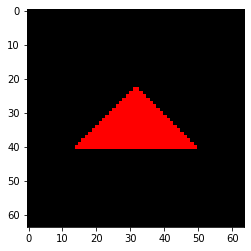

In [37]:
scene = loadTriangleScene(imgWidth, imgHeight)
print(f"Start rendering in resolution: {imgWidth}x{imgHeight}, fov: {scene.config['fov']}")
startTime = time.monotonic()
img = rasterize(scene, scene.geometry[0])
duration = time.monotonic() - startTime
print("Finished rendering, time taken:", duration, "seconds")

plt.imshow(img)

print("Writing PNG...")
plt.imsave(f"triangle-rasterization.png", img)

print("Writing EXR...")
output = np.power(img, 2.2)
pyexr.write(f"triangle-rasterization.exr", output)


---

## Question 2 - Ray Tracing - Single primitive (35 points)

We will now implement a barebones ray tracer to render the same scene (i.e., a single triangle).

**Hint:** Remember that rasterization and ray tracing are two different techniques, but solve the same problem (the primary/eye-visibility problem). You should get identical results regardless of the technique used (helpful when debugging ray tracing implementations).


In the `Triangle` class above, the following two routines need to be implemented:

- `intersect(ray)`: Check if ray intersects the current triangle, and if so, the distance to the hit point.
- `normal(hit):` Computes the triangle normal at a hit point.

After completing the `Triangle` class, implement the following ray-scene intersection method: given a `Ray` object, intersect it with all objects (here, triangles) in the scene. Determine which objects intersect this ray, and return the distance of the closest _hit_ object.

**Note**: There are often multiple objects in the scene that a ray might hit. If so, you must remember to line-search for the closest _hit_.

In [14]:
def intersect(scene, ray):
    """ 
    Method to intersect all objects in the scene
    Parameters:
        scene: scene to render.
        ray: ray to trace.
    Returns:
      (has_hit, hit_object_id, distance_to_object)
      has_hit is 0 if there is not hit, else it is 1
      id is the idx of the scene object hit
      t is the ray parameter (recall a ray is o + td) at which
        a hit is found
    """
    # TODO: implement this
    primitives = scene.geometry

    # Initialize return values
    has_hit, hit_id, t = False, -1, ray.max

    # Set up distance range
    t_min, t_max = 0., ray.max

    # loop
    for (index, primitive) in zip(range(len(primitives)), primitives):
        t = primitive.intersect(ray)
        if t_min < t < t_max:
            t_max = t
            hit_id = index
            has_hit = True
    dist = t_max
    return has_hit, hit_id, dist

Recall for a point light with intensity $\Phi$, the radiance of diffusely reflected light $L_d$ at a shading point is computed as

\begin{equation}
    L_d = \frac{\rho}{\pi} \left( \frac{\Phi}{4 \pi r^2} \right) \max\left( 0, \mathbf{n} \cdot \mathbf{l} \right),
\end{equation}

where $\rho$ is the diffuse albedo, $r$ is the distance between the shading point and the light, $\mathbf{n}$ is the surface normal and $\mathbf{l}$ is the light direction.

Implement the following `shade()` function according to the above formula.
Assume $\rho = 1$ in your code.

In [38]:
def shade(scene, hit, triangle):
    """
    Method to shade a hit point
    Parameters:
      scene: scene to render.
      hit: hit point to shade.
      triangle: hit triangle object
    Returns:
      radiance at the hit point 
    """
    # TODO: implement this
    light = scene.light
    light_pos, light_flux = light.p, np.asarray(light.e)

    cam = scene.cam
    cam_pos = cam.eye

    diff_l = light_pos - hit
    r = distance(light_pos, hit)
    li = normalize(diff_l)

    diff_c = normalize(cam_pos - hit)
    normal = triangle.normal(hit)
    tmp = 2 * (np.dot(diff_c, normal) > 0)

    n = normal * (tmp - 1)

    cosine = max(0, np.dot(n, li))
    a = light_flux / (4 * np.pi * (r ** 2))
    k = p / np.pi
    b = k * a * cosine
    radiance = b * triangle.mat.c
    radiance = np.array([min(1, radiance[0]), min(1, radiance[1]), min(1, radiance[2])])
    # radiance = triangle.mat.c
    return radiance  # Replace this with your return statement, when implementation is ready


Now trace a ray into the scene and collect the hit information.
Evaluate and return the outgoing radiance using your `shade()` method.

In [39]:
def trace(scene, ray):
    """ 
    Trace a ray in the scene, and shade the hit point
    Parameters:
      scene: scene to render
      ray: ray to trace
    Returns:
      light radiance at the hit point 
    """
    intersection = intersect(scene, ray)
    has_hit = intersection[0]
    if has_hit is False:
      return np.zeros(3)
    hit_id = intersection[1]  # object id
    t = intersection[2] # distance
    
    return shade(scene, ray.o + ray.d * t, scene.geometry[hit_id])

### Putting Everything Together ###

Now we have all the pieces of the ray tracer, let's put it together and implement the ray tracing rendering loop.
The `renderRaytracing()` function below is currently empty: complete it by looping over all pixels on the image plane and computing their color.
At a high-level, this is done as follows:

1. calculate the camera perspective, the camera-to-world transformation matrix and the aspect ratio,
2. loop over all pixels on the image plane, and
3. generate a ray through each pixel and *splat* its contribution onto the image plane.

The last step can be broken down into four (4) substeps:

1. retrieve the *pixel* center $(x, y)$,
2. construct a ray with its origin at the camera's center and its direction pointing through the pixel center,
3. transform this ray to world coordinates, taking the FoV and aspect ratio into account,
4. trace this ray into the scene and output the returned radiance contribution to the image buffer.

In [40]:
def renderRaytracing(scene):
    """
    Ray tracer main rendering function
    Parameters:
      scene: scene to render
    Returns:
      rendered image
    """
    print("Rendering the scene")

    # TODO: implement this
    # Hints:
    # 1. Set up the model view projection transforms (use the `width`, `height`,
    #    `fov` parameters from the `scene.config` dictionary for this).
    # 2. Loop over all pixels in a ray, and follow the instructions from the
    #    question to complete the ray tracing routine.
    width, height, fovy = scene.config["width"], scene.config["height"], scene.config["fov"] * np.pi / 180
    aspect = width / height
    n = cam_near
    t = n * math.tan(fovy / 2)
    r = t * aspect

    cam = scene.cam
    cam2World = np.linalg.inv(lookAt(cam.eye, cam.at, cam.up))
    x, y, z, eye = cam2World[:-1, 0], cam2World[:-1, 1], cam2World[:-1, 2], cam2World[:-1, 3]

    imgBuffer = np.zeros(shape=(height, width, 3))
    # pixelBuffer = np.zeros(shape=(width, height, 2))

    # set the pivot point at the top left
    for i in range(0, width):
        for j in range(0, height):
            u, v = -r + ((i + 0.5) * 2 * r / width), t - ((j + 0.5) * 2 * t / height)
            # pixel_Cam= np.asarray([u, v, d])
            # dir_Cam = hp.normalize(pixel_Cam)
            dir = normalize(u * x + v * y - n * z)
            ray = Ray(eye, dir)
            imgBuffer[j, i] = trace(scene, ray)

    # Return your image
    return imgBuffer

Finally, it's time to check your solution.
Run the two cells below to render and display the same triangle scene and output the result to an EXR image.

For faster debugging, we currently set `imgWidth` and `imgHeight` to `64`. **For the eventual solution, you are required to render a `512 x 512` image**. (Note that rendering at this resolution may take several minutes, so please plan ahead of time)

In [41]:
imgWidth = 64
imgHeight = 64

Start rendering in resolution: 64x64, fov: 60
Rendering the scene
Finished rendering, time taken: 0.3611749320000399 seconds
Writing PNG...
Writing EXR...


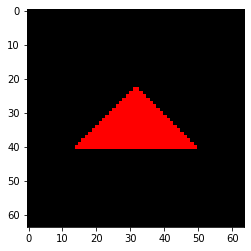

In [42]:
scene = loadTriangleScene(imgWidth, imgHeight)
print(f"Start rendering in resolution: {scene.config['width']}x{scene.config['height']}, fov: {scene.config['fov']}")
startTime = time.monotonic()
img = renderRaytracing(scene)
duration = time.monotonic() - startTime
print("Finished rendering, time taken:", duration, "seconds")

plt.imshow(img)

print("Writing PNG...")
plt.imsave(f"triangle-raytracing.png", img)

print("Writing EXR...")
output = np.power(img, 2.2)
pyexr.write(f"triangle-raytracing.exr", output)

## Question 3 - Ray tracing the Cornell Box (15 points)

Having successfully rendered a triangle, we are now ready to render the famous [*Cornell Box* scene](https://www.graphics.cornell.edu/online/box/data.html).

In this question, we will test our ray tracer code from above, on a more complex scene. If your above implementation was correct, it will NOT require any changes and should seamlessly run on the Cornell Box scene.

The code cell below loads the scene description into memory.


In [43]:
def loadCornellBox(width, height):
    objects = [
    # Floor
    Triangle([552.8, 0, 0], [0, 0, 0], [0, 0, 559.2], Diffuse([1, 1, 1])),
    Triangle([552.8, 0, 0], [0, 0, 559.2], [552.8, 0, 559.2], Diffuse([1, 1, 1])),
    # Ceiling
    Triangle([556.0, 548.8, 0.0], [556.0, 548.8, 559.2],[0.0, 548.8, 559.2], Diffuse([1, 1, 1])),
    Triangle([556.0, 548.8, 0.0], [0.0, 548.8, 559.2], [0.0, 548.8, 0.0], Diffuse([1, 1, 1])),
    # Back Wall
    Triangle([549.6, 0.0, 559.2], [0.0, 0.0, 559.2], [0.0, 548.8, 559.2], Diffuse([1, 1, 1])),
    Triangle([549.6, 0.0, 559.2], [0.0, 548.8, 559.2], [556.0, 548.8, 559.2], Diffuse([1, 1, 1])),
    # Right Wall
    Triangle([0.0, 0.0, 559.2 ], [0.0, 0.0, 0.0], [0.0, 548.8,   0.0], Diffuse([0, 1, 0])),
    Triangle([0.0, 0.0, 559.2], [0.0, 548.8, 0.0], [0.0, 548.8, 559.2], Diffuse([0, 1, 0])),
    # Left Wall
    Triangle([552.8, 0.0, 0.0], [549.6, 0.0, 559.2], [556.0, 548.8, 559.2], Diffuse([1, 0, 0])),
    Triangle([552.8, 0.0, 0.0], [556.0, 548.8, 559.2], [556.0, 548.8, 0.0], Diffuse([1, 0, 0])),
    # Short Block
    Triangle([130.0, 165.0,  65.0], [82.0, 165.0, 225.0], [240.0, 165.0, 272.0],  Diffuse([1, 1, 1])),
    Triangle([130.0, 165.0,  65.0], [240.0 ,165.0, 272.0], [290.0, 165.0, 114.0], Diffuse([1, 1, 1])),
    Triangle([290.0, 0.0, 114.0], [290.0, 165.0, 114.0], [240.0, 165.0, 272.0], Diffuse([1, 1, 1])),
    Triangle([290.0, 0.0, 114.0], [240.0, 165.0, 272.0], [240.0, 0.0, 272.0], Diffuse([1, 1, 1])),
    Triangle([130.0, 0.0, 65.0], [130.0, 165.0, 65.0], [290.0, 165.0, 114.0], Diffuse([1, 1, 1])),
    Triangle([130.0, 0.0, 65.0], [290.0, 165.0, 114.0], [290.0, 0.0, 114.0], Diffuse([1, 1, 1])),
    Triangle([82.0, 0.0, 225.0], [82.0, 165.0, 225.0], [130.0, 165.0, 65.0], Diffuse([1, 1, 1])),
    Triangle([82.0, 0.0, 225.0], [130.0, 165.0, 65.0], [130.0, 0.0, 65.0], Diffuse([1, 1, 1])),
    Triangle([240.0, 0.0, 272.0], [240.0, 165.0, 272.0], [82.0, 165.0, 225.0], Diffuse([1, 1, 1])),
    Triangle([240.0, 0.0, 272.0], [82.0, 165.0, 225.0], [82.0, 0.0, 225.0], Diffuse([1, 1, 1])),
    # Tall Block
    Triangle([423.0, 330.0, 247.0], [265.0, 330.0, 296.0], [314.0, 330.0, 456.0], Diffuse([1, 1, 1])),
    Triangle([423.0, 330.0, 247.0], [314.0, 330.0, 456.0], [472.0, 330.0, 406.0], Diffuse([1, 1, 1])),
    Triangle([423.0, 0.0, 247.0], [423.0, 330.0, 247.0], [472.0, 330.0, 406.0], Diffuse([1, 1, 1])),
    Triangle([423.0, 0.0, 247.0], [472.0, 330.0,  406.0], [472.0, 0.0, 406.0], Diffuse([1, 1, 1])),
    Triangle([472.0, 0.0, 406.0], [472.0, 330.0,406.0], [314.0, 330.0, 456.0], Diffuse([1, 1, 1])),
    Triangle([472.0, 0.0, 406.0], [314.0, 330.0, 456.0], [314.0, 0.0, 456.0], Diffuse([1, 1, 1])),
    Triangle([314.0, 0.0, 456.0], [314.0, 330.0, 456.0], [265.0, 330.0, 296.0], Diffuse([1, 1, 1])),
    Triangle([314.0, 0.0, 456.0], [265.0,  330.0, 296.0], [265.0, 0.0, 296.0], Diffuse([1, 1, 1])),
    Triangle([265.0, 0.0, 296.0], [265.0, 330.0, 296.0], [423.0, 330.0, 247.0], Diffuse([1, 1, 1])),
    Triangle([265.0, 0.0, 296.0], [423.0, 330.0, 247.0], [423.0, 0.0, 247.0], Diffuse([1, 1, 1])),
    ]
    light = PointLight([278, 508, 279.5], [5e6, 5e6, 5e6])
    camera = Camera(np.array([278, 273 , -800]),np.array([278, 273, 0]), np.array([0, 1, 0]))
    config = { "width": width, "height": height, "fov": 38 }
    return Scene(objects, light, camera, config)

If all of your ray tracing code is correctly set up, the following code cell should produce an image of the Cornell Box scene. Note that the orignal image may be accessed at [this webpage](https://www.graphics.cornell.edu/online/box/data.html).

Since we currently use a low resolution output image (64 x 64), rendering should take about 20 seconds (on a Google Colab CPU-only instance). Once you are satisfied with the output, **render a 512 x 512 image**. This image will be the deliverable for this question.

(Note that rendering at a `512 x 512` resolution may take several minutes, so please plan ahead of time)

In [44]:
imgWidth = 64
imgHeight = 64

Start rendering in resolution: 64x64, fov: 38
Rendering the scene
Finished rendering, time taken: 5.593927496000106 seconds
Writing PNG...
Writing EXR...


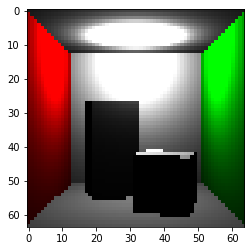

In [45]:
scene = loadCornellBox(imgWidth, imgHeight)
print(f"Start rendering in resolution: {imgWidth}x{imgHeight}, fov: {scene.config['fov']}")
startTime = time.monotonic()
img = renderRaytracing(scene)
duration = time.monotonic() - startTime
print("Finished rendering, time taken:", duration, "seconds")

plt.imshow(img)

print("Writing PNG...")
plt.imsave(f"cbox-raytracing.png", img)

print("Writing EXR...")
output = np.power(img, 2.2)
pyexr.write(f"cbox-raytracing.exr", output)

## Question 4 - Rasterizing the Cornell Box (25 points)

For rasterizing the Cornell Box scene, we will need to implement a Z-buffer, to ensure only the object closest to the camera at each pixel is rendered. Recall that, for a triangle, we only had a single primitive; hence we did not need to perform Z-buffering.

In this question, you will modify the `rasterize()` method you implemented in Question 1, and will implement a more general `renderRasterization()` method that includes a visibility test by means of a Z-buffer. In particular:
* Factor in the position and intensity of the scene's position light
* Initialize a Z-buffer (an array of size equal to that of pixels in the output image). Initialize depth for each pixel to a large value or infinity (`np.inf`).
* Loop over all triangles, and rasterize them (keeping in mind the bullet points below)
* Compute the depth with respect to the camera ($z^{'}$) by interpolating the pixel location within each triangle's vertices.
* If the new depth (w.r.t. the camera) is smaller than the value stored in the Z-buffer for the pixel, shade the pixel using the diffuse reflection of this new triangle at the shade point.

Hint: keep visualizing intermediate stages of your Z-buffer to get a better sense for debugging.

In [65]:
def renderRasterization(scene):
    # DO NOT modify these three lines
    width = scene.config["width"]
    height = scene.config["height"]
    img = np.zeros((height, width, 3))

    zbuf = np.full((height, width), np.inf)
    # TODO: Implement the rasterization loop here

    # transformation matrix from world space to NDC space
    fovy = scene.config["fov"]
    PVM = perspective(fovy * math.pi / 180, width / height, 0.1, 10) @ lookAt(scene.cam.eye, scene.cam.at,
                                                                                    scene.cam.up)

    # set up point light
    light_pos = np.asarray(scene.light.p)
    light_em = np.asarray(scene.light.e)
    
    for obj in scene.geometry:
        rasterize_q4(scene, obj, img, zbuf)
    return img

Finally, rasterize the Cornell Box by running the two cells below.
The rendered result should look identical to what you get with ray tracing.

For faster debugging, we currently set `imgWidth` and `imgHeight` to `64`. **For the eventual solution, you are required to render a `512 x 512` image**. (Note that rendering at this resolution may take several minutes, so please plan ahead of time).

In [66]:
imgWidth = 64
imgHeight = 64

Start rendering in resolution: 64x64, fov: 38
Finished rendering, time taken: 2.0156699229992228 seconds
Writing PNG...
Writing EXR...


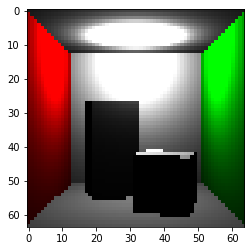

In [71]:
scene = loadCornellBox(imgWidth, imgHeight)
print(f"Start rendering in resolution: {imgWidth}x{imgHeight}, fov: {scene.config['fov']}")
startTime = time.monotonic()
img = renderRasterization(scene)
duration = time.monotonic() - startTime
print("Finished rendering, time taken:", duration, "seconds")

plt.imshow(img)

print("Writing PNG...")
plt.imsave(f"cbox-rasterization.png", img)

print("Writing EXR...")
output = np.power(img, 2.2)
pyexr.write(f"cbox-rasterization.exr", output)

---

## **Bonus Questions**

The following questions are for **extra credit**, and are not mandatory.

**Only attempt this part if you have finished all required questions**. These questions build atop Questions 1 through 4.

**No partial points will be awarded on these questions.**

**You may choose to attempt one or more bonus questions, and in no particular order**.

The bonus questions are not autograded -- you are free to use as many cells and define functions as needed. You may not, however, import libraries other than those approved for this assignment. If in doubt, please talk to the TAs or the instructor.

## Bonus Question 1 - Shading normals (15 points)

This question involves computing the shading normals for a triangle mesh.

Download the Stanford bunny `.obj` file available [here](https://graphics.stanford.edu/~mdfisher/Data/Meshes/bunny.obj). Read it into a `numpy` array (you may use the `ObjLoader` class provided [here](https://inareous.github.io/posts/opening-obj-using-py)).

Note how the bunny obj file only has vertex and face information, but no normals? The objective of this bonus question is to compute the _shading normals_ for this triangle mesh and render it using your choice of rasterization / ray tracing implementation from above. With proper shading normals, the bunny should look smooth (except at the silhouettes), instead of faceted).

(Hint: you will find the discussion on shading normals from the end of the rasterization module slides useful.)

## Bonus Question 2 - Phong illumination (15 points)

For this bonus question, you will implement a Phong BRDF / reflection model. Recall, from the lectures on phenomenological shading and appearance models how Phong specular reflection models work. Augment the ray tracer you just implemented by adding a Phong illumination model to get realistic reflections of the light source on object surfaces.

In [97]:
def shade_phong(scene, hit, triangle, kd = 0.6, ks = 0.5, p = 8):
    """
        Method to shade a hit point
        Parameters:
          scene: scene to render.
          hit: hit point to shade.
          triangle: hit triangle object
          kd: diffuse coefficient
          ks: specular coefficient
        Returns:
          radiance at the hit point
        """
    # TODO: implement this
    light = scene.light
    light_pos, light_flux = light.p, np.asarray(light.e)

    cam = scene.cam

    r_i = distance(light_pos, hit)
    l_i = normalize(light_pos - hit)

    r_cam = distance(cam.eye, hit)
    l_cam =  normalize(cam.eye - hit)

    h = normalize(l_cam + l_i)

    n_tmp = triangle.normal(hit)
    n = (2 * (np.dot(l_cam, n_tmp) > 0) - 1) * n_tmp

    
    

    # Compute Diffuse Reflection
    I = light_flux / (4 * np.pi ** 2 * (r_i ** 2))
    L_diffuse = I * max([0, np.dot(n, l_i)])

    # Compute Phong Reflection
    lambertian = max(np.dot(-n, l_i), 0.0)
    L_specular = 0.
    if lambertian > 0.:
        r_r = normalize(-l_i - 2* np.dot(-l_i, n) * n)
        L_specular = math.pow(max(0, np.dot(r_r, l_cam)), p)

    # Add together
    radiance_unclip = kd * L_diffuse * triangle.mat.c + ks * L_specular * np.array(([1,1,1]))
    radiance = np.array(([min(1, v) for v in radiance_unclip]))
    return radiance # Replace this with your return statement, when implementation is ready


def trace_phong(scene, ray):
    """
        Trace a ray in the scene, and shade the hit point
        Parameters:
          scene: scene to render
          ray: ray to trace
        Returns:
          light radiance at the hit point
        """
    intersection = intersect(scene, ray)
    has_hit = intersection[0]
    if has_hit is False:
        return np.zeros(3)
    hit_id = intersection[1]  # object id
    t = intersection[2]  # distance

    return shade_phong(scene, ray.o + ray.d * t, scene.geometry[hit_id])


def renderRaytracing_phong(scene):
    """
        Ray tracer main rendering function
        Parameters:
          scene: scene to render
        Returns:
          rendered image
        """
    print("Rendering the scene")

    # TODO: implement this
    # Hints:
    # 1. Set up the model view projection transforms (use the `width`, `height`,
    #    `fov` parameters from the `scene.config` dictionary for this).
    # 2. Loop over all pixels in a ray, and follow the instructions from the
    #    question to complete the ray tracing routine.
    width, height, fovy = scene.config["width"], scene.config["height"], scene.config["fov"] * np.pi / 180
    aspect = width / height
    n = cam_near
    t = n * math.tan(fovy / 2)
    r = t * aspect

    cam = scene.cam
    cam2World = np.linalg.inv(lookAt(cam.eye, cam.at, cam.up))
    x, y, z, eye = cam2World[:-1, 0], cam2World[:-1, 1], cam2World[:-1, 2], cam2World[:-1, 3]

    imgBuffer = np.zeros(shape=(height, width, 3))
    # pixelBuffer = np.zeros(shape=(width, height, 2))

    # set the pivot point at the top left
    for i in range(0, width):
        for j in range(0, height):
            u, v = -r + ((i + 0.5) * 2 * r / width), t - ((j + 0.5) * 2 * t / height)
            # pixel_Cam= np.asarray([u, v, d])
            # dir_Cam = hp.normalize(pixel_Cam)
            dir = normalize(u * x + v * y - n * z)
            ray = Ray(eye, dir)
            imgBuffer[j, i] = trace_phong(scene, ray)

    # Return your image
    return imgBuffer

Rendering the scene
Finished rendering, time taken: 5.77394928800004 seconds


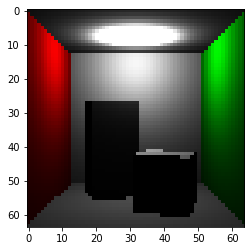

Writing PNG...
Writing EXR...


In [98]:
imgWidth = 512
imgHeight = 512
scene = loadCornellBox(imgWidth, imgHeight)
startTime = time.monotonic()
img = renderRaytracing_phong(scene)
duration = time.monotonic() - startTime
print("Finished rendering, time taken:", duration, "seconds")
plt.imshow(img)
plt.show()
print("Writing PNG...")
plt.imsave(f"cbox-raytracing-phong.png", img)
print("Writing EXR...")
output = np.power(img, 2.2)

## Bonus Question 3 - Ray tracing with hard shadows (25 points)

Notice how your ray tracing outputs do not contain any shadows? In this bonus question, you will perform ray tracing with additional _shadow rays_. In the phenomenological shading module, we saw how to extend the `trace()` routine to cast an additional shadow ray to determine whether a shade point is in  shadow w.r.t. a light source. We recommend you do this on the Cornell Box scene, but remember to use a low resolution image for debugging.

In [84]:
def shade_shadow(scene, hit, triangle):
    """
        Method to shade a hit point
        Parameters:
          scene: scene to render.
          hit: hit point to shade.
          triangle: hit triangle object
        Returns:
          radiance at the hit point
        """
    # TODO: implement this
    light = scene.light
    light_pos, light_flux = light.p, np.asarray(light.e)

    cam = scene.cam
    cam_pos = cam.eye

    diff_l = light_pos - hit
    r = distance(light_pos, hit)
    li = normalize(diff_l)

    ray = Ray(light_pos, -li, r)
    hasblocked = any(tri.intersect(ray) != 0 for tri in scene.geometry)
    if not hasblocked:
        diff_c = normalize(cam_pos - hit)
        normal = triangle.normal(hit)
        tmp = 2 * (np.dot(diff_c, normal) > 0)

        n = normal * (tmp - 1)

        cosine = max(0, np.dot(n, li))
        a = light_flux / (4 * np.pi * (r ** 2))
        k = p / np.pi
        b = k * a * cosine
        radiance = b * triangle.mat.c
        radiance = np.array([min(1, radiance[0]), min(1, radiance[1]), min(1, radiance[2])])
        # radiance = triangle.mat.c
        return radiance  # Replace this with your return statement, when implementation is ready
    else:
        return np.zeros(3)

def trace_shadow(scene, ray):
    """
        Trace a ray in the scene, and shade the hit point
        Parameters:
          scene: scene to render
          ray: ray to trace
        Returns:
          light radiance at the hit point
        """
    intersection = intersect(scene, ray)
    has_hit = intersection[0]
    if has_hit is False:
        return np.zeros(3)
    hit_id = intersection[1]  # object id
    t = intersection[2]  # distance

    return shade_shadow(scene, ray.o + ray.d * t, scene.geometry[hit_id])

def renderRaytracing_shadow(scene):
    """
        Ray tracer main rendering function
        Parameters:
          scene: scene to render
        Returns:
          rendered image
        """
    print("Rendering the scene")

    # TODO: implement this
    # Hints:
    # 1. Set up the model view projection transforms (use the `width`, `height`,
    #    `fov` parameters from the `scene.config` dictionary for this).
    # 2. Loop over all pixels in a ray, and follow the instructions from the
    #    question to complete the ray tracing routine.
    width, height, fovy = scene.config["width"], scene.config["height"], scene.config["fov"] * np.pi / 180
    aspect = width / height
    n = cam_near
    t = n * math.tan(fovy / 2)
    r = t * aspect

    cam = scene.cam
    cam2World = np.linalg.inv(lookAt(cam.eye, cam.at, cam.up))
    x, y, z, eye = cam2World[:-1, 0], cam2World[:-1, 1], cam2World[:-1, 2], cam2World[:-1, 3]

    imgBuffer = np.zeros(shape=(height, width, 3))
    # pixelBuffer = np.zeros(shape=(width, height, 2))

    # set the pivot point at the top left
    for i in range(0, width):
        for j in range(0, height):
            u, v = -r + ((i + 0.5) * 2 * r / width), t - ((j + 0.5) * 2 * t / height)
            # pixel_Cam= np.asarray([u, v, d])
            # dir_Cam = hp.normalize(pixel_Cam)
            dir = normalize(u * x + v * y - n * z)
            ray = Ray(eye, dir)
            imgBuffer[j, i] = trace_shadow(scene, ray)

    # Return your image
    return imgBuffer

imgWidth = 64
imgHeight = 64
scene = loadCornellBox(imgWidth, imgHeight)
startTime = time.monotonic()
img = renderRaytracing_shadow(scene)
duration = time.monotonic() - startTime
print("Finished rendering, time taken:", duration, "seconds")

plt.imshow(img)
plt.show()
print("Writing PNG...")
plt.imsave(f"cbox-rasterization.png", img)

print("Writing EXR...")
output = np.power(img, 2.2)

Rendering the scene


KeyboardInterrupt: ignored